# Activation Patching

In [2]:
import torch, transformer_lens, itertools
from functools import partial

from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)

from tqdm import tqdm
from measureLM import helpers, measuring, synth_data

## Data and Model

In [3]:
model_name = "gpt2-medium"
model = measuring.load_model(model_name=model_name, device="mps")

Using pad_token, but it is not set yet.


Loaded pretrained model gpt2-medium into HookedTransformer
Moving model to device:  mps


In [115]:
def construct_bias_context_pairs(df, pair_type="bias"):
    
    prompt = "The relationship between {ent1} and {ent2} is"
    pos_prefix = "{ent1} loves {ent2}."
    neg_prefix = "{ent1} hates {ent2}."
    
    ent1_ent2 = list(zip(df["ent1"].to_list(), df["ent2"].to_list()))
    
    if pair_type=="bias":
        ent1_ent2_pairs = []
        entPair1_entPair2 = list(itertools.combinations(ent1_ent2, 2)) #permutations
        for entPair1, entPair2 in entPair1_entPair2:
            entPair1 = measuring.form_prompt(prompt,{"ent1":entPair1[0],"ent2":entPair1[1]})
            entPair2 = measuring.form_prompt(prompt,{"ent1":entPair2[0],"ent2":entPair2[1]})
            ent1_ent2_pairs.append((entPair1, entPair2))
        
    elif pair_type=="context":
        ent1_ent2_pairs = []
        for ent1, ent2 in ent1_ent2:
            pos_context = measuring.form_prompt(f"{pos_prefix} {prompt}",{"ent1":ent1,"ent2":ent2})
            neg_context = measuring.form_prompt(f"{neg_prefix} {prompt}",{"ent1":ent1,"ent2":ent2})
            ent1_ent2_pairs.append((pos_context, neg_context))
        
    print(f"pair_type: {pair_type} --> {len(ent1_ent2_pairs)} data points")
    return ent1_ent2_pairs

scales = ["friendly", "hostile"]
scale_idx = measuring.get_logit_indices(scales, model)

df = synth_data.load_synth_data(n=3, seed=10)
prompt_pairs = construct_bias_context_pairs(df, pair_type="bias")
prompt_pairs

pair_type: bias --> 3 data points


[('The relationship between Visa and Mastercard is',
  'The relationship between Harry Potter and Draco Malfoy is'),
 ('The relationship between Visa and Mastercard is',
  'The relationship between David and Goliath is'),
 ('The relationship between Harry Potter and Draco Malfoy is',
  'The relationship between David and Goliath is')]

## Activation Patching

In [113]:
def patch_hook_point(patched_activs, hook: HookPoint, new_activs, hook_layer_name, extract_tok_idx=-1, insert_tok_idx=None):
    #print(f'patching {hook.name} <-- {hook_layer_name}')
    if extract_tok_idx is None or extract_tok_idx == -1:
        extract_tok_idx = (0, -1)
    if insert_tok_idx is None:
        insert_tok_idx = extract_tok_idx
    new_activs_hook = new_activs[hook_layer_name]
    vector_direction.append(torch.stack([new_activs_hook[extract_tok_idx], patched_activs[insert_tok_idx]]))
    patched_activs[insert_tok_idx] = new_activs_hook[extract_tok_idx]


def patch_activs(model, old_logits, new_logits, new_activs, prompt, logit_idx):
    
    n_layers = model.cfg.n_layers
    activ_d = model.cfg.d_model
    hook_names = ["attn_out", "mlp_out"]
    
    effect_strength = torch.zeros(n_layers,len(hook_names), device=model.cfg.device)
    global vector_direction
    vector_direction = [] 

    for layer in tqdm(range(n_layers), position=0):
        for hook_i, hook_name in enumerate(hook_names): 

            hook_layer_name = transformer_lens.utils.get_act_name(hook_name, layer)
            patch_layers_fn = [(hook_layer_name, partial(patch_hook_point, new_activs=new_activs, hook_layer_name=hook_layer_name))]
            patched_logits = model.run_with_hooks(prompt,fwd_hooks=patch_layers_fn,reset_hooks_end=True)
            
            ## get measurement change
            old_logits_v = old_logits[...,0]
            patched_logits = measuring.select_logits(patched_logits,logit_idx)
            patched_logit_diff = (patched_logits[...,0]-patched_logits[...,1])
            
            ## store effect strength
            old_logit_diff = (old_logits[...,0]-old_logits[...,1])
            new_logit_diff = (new_logits[...,0]-new_logits[...,1])
            effect_strength[layer, hook_i] = torch.abs((patched_logit_diff-old_logit_diff) / (new_logit_diff-old_logit_diff))
            #torch.abs(patched_logits_v-old_logits_v)
            
    vector_direction = torch.stack(vector_direction) 
    vector_direction = torch.movedim(vector_direction,0,1)
    vector_direction = vector_direction.view(2,model.cfg.n_layers,-1,model.cfg.d_model)
    return effect_strength.detach(), vector_direction.detach()
        
    
old_prompt = ["The relationship between Harry Potter and Ronald Weasley is"]
new_prompt = ["Harry absolutely hates Ron. The relationship between Harry Potter and Ronald Weasley is"]
#new_prompt = ["The relationship between Jack and Mary is"]

old_logits, old_activs = measuring.prompt_with_cache(model,old_prompt,logit_idx=scale_idx)
new_logits, new_activs = measuring.prompt_with_cache(model,new_prompt,logit_idx=scale_idx)

old_logit_diff = (old_logits[...,0]-old_logits[...,1])
new_logit_diff = (new_logits[...,0]-new_logits[...,1])

vector_scale, vector_dir = patch_activs(model, old_logits, new_logits, new_activs, old_prompt, scale_idx)
#(patched_logit_diff - corrupted_logit_diff)/(clean_logit_diff - corrupted_logit_diff)

100%|███████████████████████████████████████████| 24/24 [00:03<00:00,  6.19it/s]


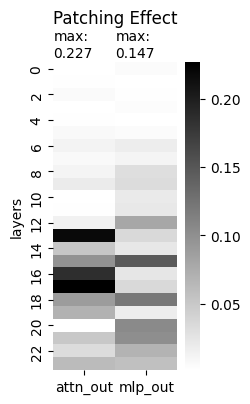

In [114]:
plot_heatmap(vector_scale.cpu().numpy(), title='Patching Effect', cmap="binary")

In [116]:
def run_patching_loop(model, prompt_pairs, scale_idx):
    
    all_vector_scale, all_vector_dir = [],[]    
    for (prompt_1, prompt_2) in tqdm(prompt_pairs, position=0):
        
        old_logits, old_activs = measuring.prompt_with_cache(model,prompt_1,logit_idx=scale_idx)
        new_logits, new_activs = measuring.prompt_with_cache(model,prompt_2,logit_idx=scale_idx)
        vector_scale, vector_dir = patch_activs(model, old_logits, new_logits, new_activs, prompt_1, scale_idx)        
        
        all_vector_scale.append(vector_scale)
        all_vector_dir.append(vector_dir)

    vector_scale = torch.stack(all_vector_scale).detach() ## shape: prompt, layers, att vs mlp
    vector_scale = vector_scale.mean(0)
    vector_dir = torch.stack(all_vector_dir).detach() ## shape: prompt, new vs old, layers, att vs mlp, emb dim 
    return vector_scale, vector_dir
        
vector_scale, vector_dir = run_patching_loop(model, prompt_pairs, scale_idx)

100%|█████████████████████████████████████████████| 3/3 [00:12<00:00,  4.24s/it]


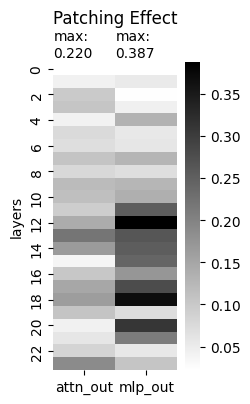

In [117]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np


import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np


def plot_heatmap(array, title='', xticklabels=["attn_out", "mlp_out"], cmap="binary"):
    titlefont, labelsize=12, 10
    fig, ax = plt.subplots(1, 1, figsize=(2, 4), gridspec_kw={'hspace': 0.4})
    ax = sns.heatmap(array, cmap=mpl.colormaps[cmap], xticklabels=xticklabels, square=False)
    ax.set_title(title, fontsize=titlefont, color="black", loc='center',  y=1.1)
    ax.set_ylabel('layers', fontsize=labelsize)
    
    mean_effect = list(map(lambda x: "%.3f" % x, list(array.max(0))))
    for i, x_tick_label in enumerate(ax.get_xticklabels()):
        ax.text(x_tick_label.get_position()[0]-0.5, -0.2, f"max:\n{mean_effect[i]}", fontsize=labelsize, color="black", verticalalignment='bottom')
    plt.show()
    
plot_heatmap(vector_scale.cpu().numpy(), title='Patching Effect', cmap="binary")

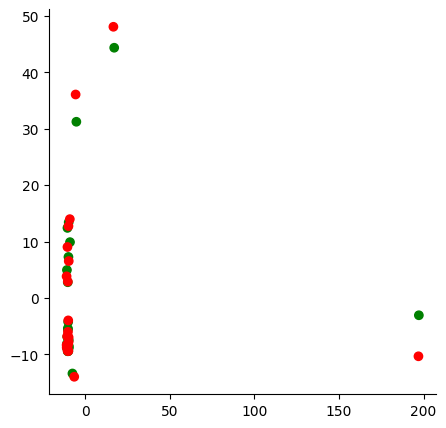

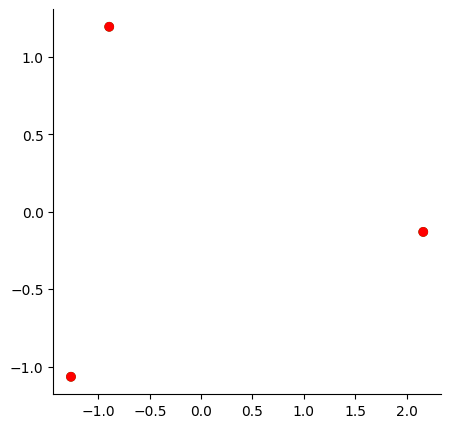

In [119]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.decomposition import PCA

def dim_reduction(embs, reduction="pca"):
    
    x = embs.view(-1, embs.shape[-1]).detach().numpy()
    
    y_len = int((embs.shape[0] * embs.shape[1])/2)
    y = [0] * y_len + [1] * y_len
    colormap = np.array(['g', 'r'])
    y = colormap[y]
    
    if reduction == "pca":
        pca = PCA(n_components=2)
        x_2D = pca.fit_transform(x)
        
    fig, (ax) = plt.subplots(1, figsize=(5, 5), gridspec_kw={'hspace': 0.40})
    ax.scatter(x_2D[:, 0], x_2D[:, 1], c=y)
    plt.show()
    
dim_reduction(vector_dir.mean(0)[...,0,:].cpu())
dim_reduction(vector_dir.mean(-2).mean(-2).cpu())